                                   Sentimental Analysis of Amazon Dataset
Sentiment analysis is the measurement of positive and negative language. It is a way to evaluate written or spoken language to determine if the expression is favorable, unfavorable, or neutral, and to what degree. Today’s algorithm-based sentiment analysis tools can handle huge volumes of customer feedback consistently and accurately. Paired with text analytics, sentiment analysis reveals the customer’s opinion about topics ranging from your products and services to your location, your advertisements, or even your competitors. With our dataset of ‘Amazon’s Fine Food Reviews’, we aim to build a prediction model where we will be able to predict if a review is positive or negative. In addition to that, we shall also filter out the products which have got the most reviews and ratings. We will be focusing on the textual reviews along with the food ratings to create accurate prediction. Often ratings are ignored in the interest of textual reviews which might lead to improper and irregular reviews. We aim to take both in account and hence counter the problem.


# Loading the data
In order to load the data, we will use the SQLITE dataset where we will only fetch the Score and the recommendation summary.

As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative".

The data will be split into an training set and a test set with a test set ratio of 0.2



In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from itertools import chain
from nltk import ngrams

In [2]:
reviews1 = pd.read_csv('E:\Reviews.csv')

In [3]:
reviews1.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [4]:
con = sqlite3.connect('E:\database.sqlite')

pd.read_sql_query("SELECT * FROM Reviews LIMIT 3", con)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

# Let's select only what's of interest to us:

In [5]:
messages = pd.read_sql_query("""
SELECT 
  Score, 
  Summary,
  Text,
  HelpfulnessNumerator as VotesHelpful, 
  HelpfulnessDenominator as VotesTotal
FROM Reviews 
WHERE Score != 3""", con)

# Let's see what we've got:

In [6]:
#Lets see how we got the data
messages.head()

Score                Summary  \
0      5  Good Quality Dog Food   
1      1      Not as Advertised   
2      4  "Delight" says it all   
3      2         Cough Medicine   
4      5            Great taffy   

                                                Text  VotesHelpful  VotesTotal  
0  I have bought several of the Vitality canned d...             1           1  
1  Product arrived labeled as Jumbo Salted Peanut...             0           0  
2  This is a confection that has been around a fe...             1           1  
3  If you are looking for the secret ingredient i...             3           3  
4  Great taffy at a great price.  There was a wid...             0           0

Let's add the Sentiment column that turns the numeric score into either positive or negative.

Similarly, the Usefulness column turns the number of votes into a boolean.

In [7]:
messages["Sentiment"] = messages["Score"].apply(lambda score: "positive" if score > 3 else "negative")
messages["Usefulness"] = (messages["VotesHelpful"]/messages["VotesTotal"]).apply(lambda n: "useful" if n > 0.8 else "useless")

messages.head(5)

Score                Summary  \
0      5  Good Quality Dog Food   
1      1      Not as Advertised   
2      4  "Delight" says it all   
3      2         Cough Medicine   
4      5            Great taffy   

                                                Text  VotesHelpful  \
0  I have bought several of the Vitality canned d...             1   
1  Product arrived labeled as Jumbo Salted Peanut...             0   
2  This is a confection that has been around a fe...             1   
3  If you are looking for the secret ingredient i...             3   
4  Great taffy at a great price.  There was a wid...             0   

   VotesTotal Sentiment Usefulness  
0           1  positive     useful  
1           0  negative    useless  
2           1  positive     useful  
3           3  negative     useful  
4           0  positive    useless

In [8]:
#Data for products whose rating is 5
messages[messages.Score == 5].head(10)

Score                                            Summary  \
0       5                              Good Quality Dog Food   
4       5                                        Great taffy   
6       5      Great!  Just as good as the expensive brands!   
7       5                             Wonderful, tasty taffy   
8       5                                         Yay Barley   
9       5                                   Healthy Dog Food   
10      5                    The Best Hot Sauce in the World   
11      5  My cats LOVE this "diet" food better than thei...   
14      5                       Strawberry Twizzlers - Yummy   
15      5           Lots of twizzlers, just what you expect.   

                                                 Text  VotesHelpful  \
0   I have bought several of the Vitality canned d...             1   
4   Great taffy at a great price.  There was a wid...             0   
6   This saltwater taffy had great flavors and was...             0   
7   This taffy is so good.  It is very soft and ch...             0   
8   Right now I'm mostly just sprouting this so my...             1   
9   This is a very healthy dog food. Good for thei...             0   
10  I don't know if it's the cactus or the tequila...             1   
11  One of my boys needed to lose some weight and ...             4   
14  The Strawberry Twizzlers are my guilty pleasur...             4   
15  My daughter loves twizzlers and this shipment ...             4   

    VotesTotal Sentiment Usefulness  
0            1  positive     useful  
4            0  positive    useless  
6            0  positive    useless  
7            0  positive    useless  
8            1  positive     useful  
9            0  positive    useless  
10           1  positive     useful  
11           4  positive     useful  
14           5  positive    useless  
15           5  positive    useless

In [10]:
#Data for products whose rating is 1
messages[messages.Score == 1].head(10)

Score                               Summary  \
1        1                     Not as Advertised   
12       1  My Cats Are Not Fans of the New Food   
26       1                       Nasty No flavor   
47       1                         Don't like it   
57       1                        stale product.   
67       1  Warning!  WARNING!  -ALCOHOL SUGARS!   
69       1                         No Tea Flavor   
90       1                                   Bad   
140      1                         Rip off Price   
150      1             Tasteless but low calorie   

                                                  Text  VotesHelpful  \
1    Product arrived labeled as Jumbo Salted Peanut...             0   
12   My cats have been happily eating Felidae Plati...             1   
26   The candy is just red , No flavor . Just  plan...             0   
47   This oatmeal is not good. Its mushy, soft, I d...             0   
57   Arrived in 6 days and were so stale i could no...             2   
67   Buyer Beware Please! This sweetener is not for...             0   
69   No tea flavor at all. Just whole brunch of art...             0   
90   I fed this to my Golden Retriever and he hated...             0   
140  These singles sell for $2.50 - $3.36 at the st...             1   
150  Seriously this product was as tasteless as the...             0   

     VotesTotal Sentiment Usefulness  
1             0  negative    useless  
12            1  negative     useful  
26            1  negative    useless  
47            7  negative    useless  
57            2  negative     useful  
67            1  negative    useless  
69            0  negative    useless  
90            1  negative    useless  
140           1  negative     useful  
150           4  negative    useless

In [11]:
#As Scikit cannot work with the words, we need to assign a new dimension to each word and work with the word counts

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanupdata = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanupdata.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

messages["Summary_Clean"] = messages["Summary"].apply(cleanup)

train, test = train_test_split(messages, test_size=0.3)
print("%d --> Training data, %d --> Test data" % (len(train), len(test)))

368069 --> Training data, 157745 --> Test data


#  Now we will apply Word Embedding Algorithms, of TFIDF and Count Vectorizer to create a matrix and then split data in testing and trainin

In [12]:
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

The code in the document is referred from: https://www.kaggle.com/eugen1701/predicting-sentiment-and-helpfulness

In [13]:
from wordcloud import WordCloud, STOPWORDS

# To cleanup stop words, add stop_words = STOPWORDS
# But it seems to function better without it
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Sentiment"]
y_test = test["Sentiment"]

prediction = dict()

# Using Wordcloud for visualisation

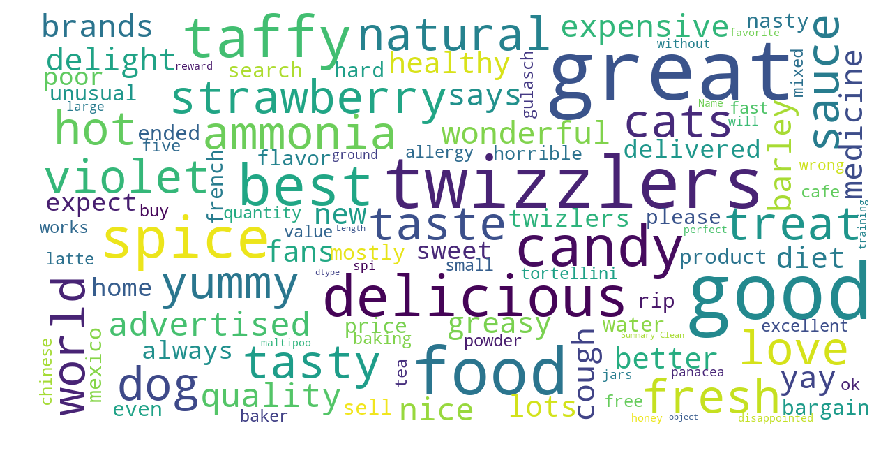

In [14]:
#Wordcloud depicting both positive as well as negative reviews
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])

We can also view wordclouds for only positive or only negative entries

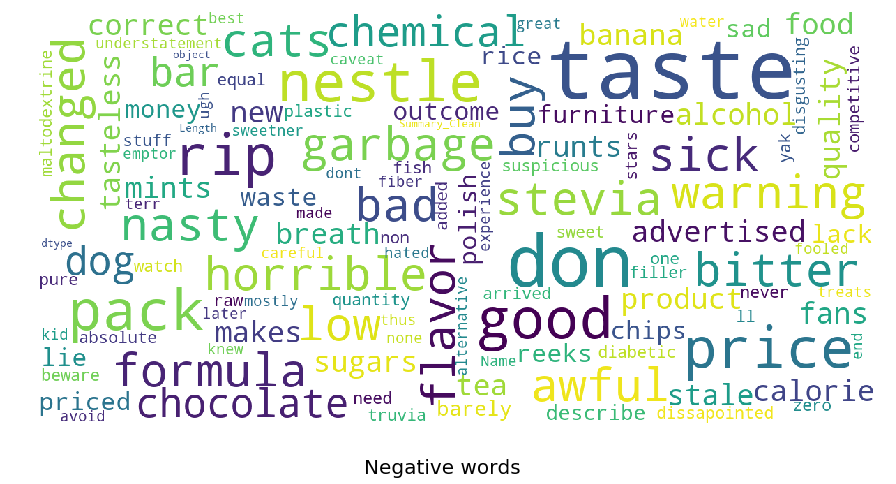

In [15]:
#Negative words which impacted the rating of the food items
show_wordcloud(messages[messages.Score == 1]["Summary_Clean"], title = "Negative words")

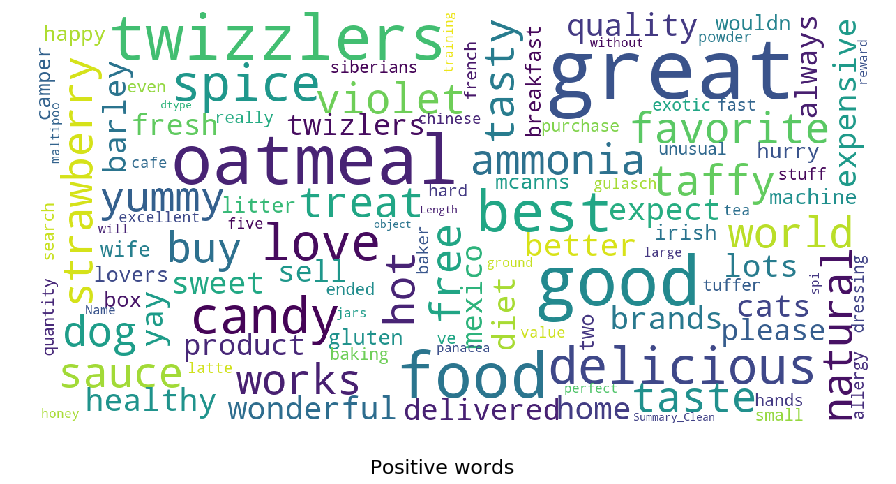

In [16]:
#Positive words which impacted the rating of the food items
show_wordcloud(messages[messages.Score == 5]["Summary_Clean"], title = "Positive words")

In [18]:
df = reviews1[reviews1['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

# Applying Logistic Regression

The code in the document by Eugen Anghel is referred from: https://www.kaggle.com/eugen1701/predicting-sentiment-and-helpfulness

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# Features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('Number of train records: {}'.format(X_train.shape[0]))
    print('Number of test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('--- Top 20 positive words ---')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('--- Top 20 negative words ---')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# Features: 114969
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.938769455474919

--- Top 20 positive words ---
Coefficient           Word
   3.327996     pleasantly
   3.192992  emeraldforest
   3.008159        chedder
   2.560361        easiest
   2.449253        solving
   2.437108        blowout
   2.370756      addicting
   2.369831       heartier
   2.294373     unwrapping
   2.291376       drawback
   2.291095          herrs
   2.289796         hooked
   2.272785         skewed
   2.260465         hahaha
   2.249587       downside
   2.234189     correction
   2.189918          whisk
   2.185779         ration
   2.183490         bertie
   2.166738     dishwasher

--- Top 20 negative words ---
Coefficient           Word
  -2.465116     unfinished
  -2.490250       tastless
  -2.594734        weakest
  -2.602914      overrated
  -2.692140      cancelled
  -2.729629    unappealing
  -2.739071        furious
  -2.751613     oversalted
  -2.821843 

In [20]:
#Accuracy is around 93%. However there are some insignificant words too which are of no use
#aseline accuracy

from sklearn.dummy import DummyClassifier
text_fit(X, y, c, DummyClassifier(),0)

# Features: 114969
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.7376268504571941


In [21]:
#Logistic Regression model on TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# Features: 114969
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.9346767690598993

--- Top 20 positive words ---
Coefficient        Word
  13.723380       great
  12.151526   delicious
  12.014686        best
  10.605858     perfect
   9.860438   excellent
   9.582079       loves
   9.037602      highly
   8.363346        love
   7.965681   wonderful
   7.796292     amazing
   7.629731     awesome
   7.337974        good
   7.245471  pleasantly
   7.189405        nice
   7.019252      hooked
   6.954937       yummy
   6.941973    favorite
   6.929576     pleased
   6.883329      smooth
   6.722613   fantastic

--- Top 20 negative words ---
Coefficient            Word
  -5.623714           waste
  -5.720342            poor
  -5.723165     undrinkable
  -6.010280            yuck
  -6.151451           stale
  -6.279573           worse
  -6.320312           bland
  -6.554197      disgusting
  -6.563029            weak
  -6.689535          return
  -6.7327

In [22]:
#Logistic regression model on TFIDF + ngram

from nltk import ngrams
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# Features: 3933179
Number of train records: 394360
Number of test records: 131454
Model Accuracy: 0.9454714196601093

--- Top 20 positive words ---
Coefficient              Word
  21.054577             great
  17.831601              best
  17.012872         delicious
  14.624623           perfect
  13.611160             loves
  13.272387              love
  13.144334         excellent
  11.418326              good
  11.321080         wonderful
  10.811514              nice
  10.594919          favorite
   9.691426           amazing
   9.371318           awesome
   9.143947              easy
   8.947594           pleased
   8.906614             happy
   8.715677            smooth
   8.592553             yummy
   8.466686            highly
   8.423070  highly recommend

--- Top 20 negative words ---
Coefficient            Word
  -7.807009           maybe
  -8.129029          hoping
  -8.250228       tasteless
  -8.319548           money
  -8.353005           worse
  -8.564717         th

# Applying Multinomial Naïve Bayes learning method

In [23]:
#Applying Multinomial Naive Bayes Algorithm 

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

# Applying Bernoulli Naïve Bayes learning method

In [24]:
#Applying Bernoulli Naive Bayes Algorithm

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

# Applying Logistic Regression

In [25]:
#Applying Logistic Regression 

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

The code in document by Andrew N.Yg and Micheal I. Jorden is referred from https://papers.nips.cc/paper/2020-on-discriminative-vs-generative-classifiers-a-comparison-of-logistic-regression-and-naive-bayes

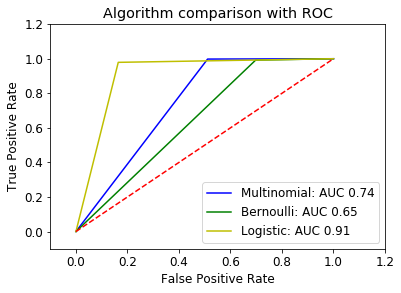

In [26]:
#To compare Multinomail Naive Bayes, Bernoulli Naive Bayes and Logistic Regression let's build a ROC curve.
#The curve which will give highest AUC value will be the best algorithm for us.

def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Algorithm comparison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After plotting the ROC curve, it would appear that the Logistic regression method provides us with the best results.

In [27]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.88      0.84      0.86     24585
   negative       0.97      0.98      0.97    133160

avg / total       0.96      0.96      0.96    157745



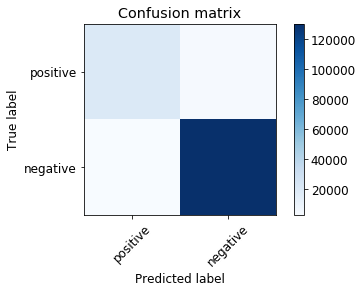

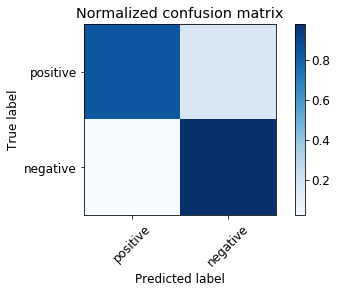

In [28]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

# Results

In [29]:
#Lets predict whether the text samples are positive or negative 

def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "I just started using this product so I think it is too soon to rate")
test_sample(logreg, "Food was delicious but smell was awful")
test_sample(logreg, "The food was ok, I guess. The smell wasn't very good, but the taste was ok.")

Sample estimated as POSITIVE: negative prob 0.003821, positive prob 0.996179
Sample estimated as NEGATIVE: negative prob 0.999925, positive prob 0.000075
Sample estimated as POSITIVE: negative prob 0.451106, positive prob 0.548894


# Study on user behaviour

In [31]:

#This analysis will be carried out to focus on one specific user, on what he / she likes in terms of fine food, 
#based on the reviews he / she had given in the past. This can be expanded to all users later on.

df_user = reviews1.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


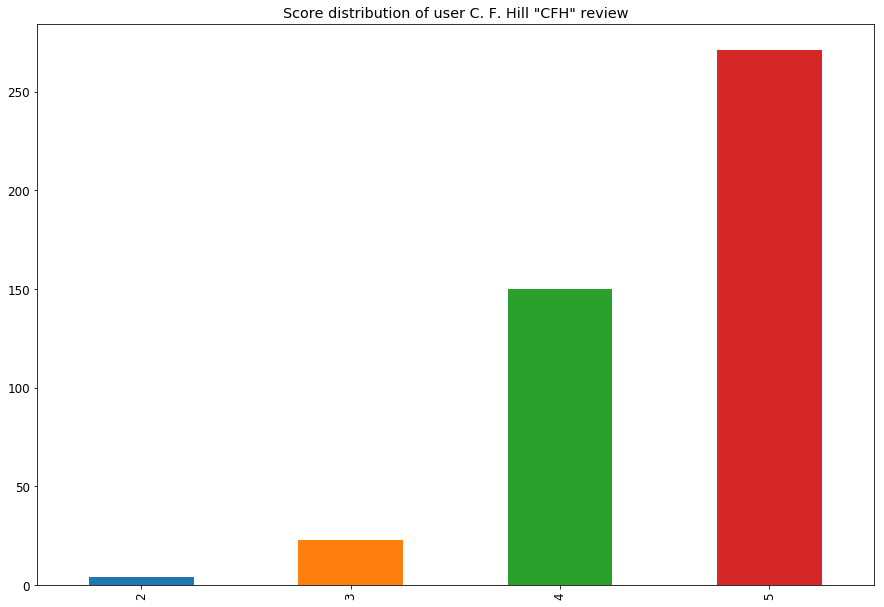

In [35]:
#The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. 
#Let's look at his review distribution:

def plot_user(UserId):
    df_1user = reviews1[reviews1['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(reviews1[reviews1['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

In [36]:
#looks user "CFH" prefer to give high score a lot. We will rather analyze a more neutral user

print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


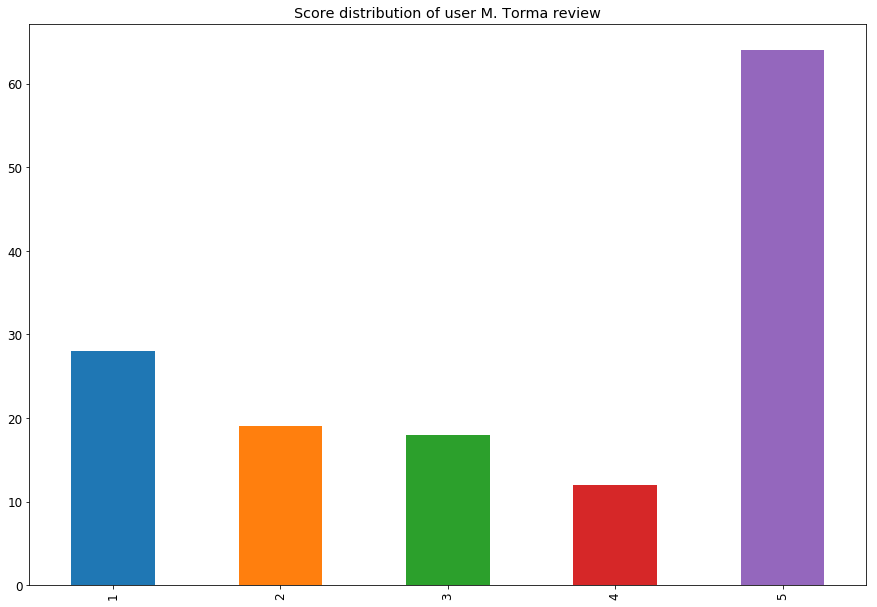

In [37]:
#M.Torma seems a good target

plot_user('A35R32TA60XD57')

In [46]:
#He seems like a better analysis target! Now let's dig deep into his reviews

def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = reviews1[(reviews1['UserId'] == userid) & (reviews1['Score'] == score)]['Text']
    else:
        df = reviews1[reviews1['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
 
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A35R32TA60XD57')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
     Count Occur %                    Phrase
0     19.0  67.86%             (would, have)
1     18.0  64.29%             (have, awful)
2     18.0  64.29%               (the, beef)
3     18.0  64.29%       (the, beef, flavor)
4     18.0  64.29%            (beef, flavor)
5     15.0  53.57%               (there, be)
6     15.0  53.57%                 (do, n't)
7     14.0   50.0%                (the, can)
8     14.0   50.0%               (this, one)
9     13.0  46.43%                 (be, the)
10    13.0  46.43%               (some, the)
12    12.0  42.86%               (will, not)
11    12.0  42.86%               (and, have)
13    11.0  39.29%             (the, flavor)
14    11.0  39.29%              (with, this)
15    11.0  39.29%        (the, ingredients)
16    11.0  39.29%                 (and, be)
24    10.0  35.71%                (n't, eat)
31    10.0  35.71%            (because, the)
30    10.0  35.71%              (buy, again)
29    10.

     Count  Occur %                         Phrase
0     13.0  108.33%                    (and, that)
1      9.0    75.0%                   (seem, like)
2      8.0   66.67%                     (but, n't)
4      8.0   66.67%                     (that, be)
3      8.0   66.67%                    (have, say)
5      7.0   58.33%                    (this, one)
11     6.0    50.0%                (and, that, be)
16     6.0    50.0%                    (lamb, and)
15     6.0    50.0%                   (type, food)
14     6.0    50.0%                (have, say, be)
12     6.0    50.0%                  (would, have)
13     6.0    50.0%                    (food, but)
10     6.0    50.0%             (lighter, variety)
9      6.0    50.0%               (food, but, n't)
8      6.0    50.0%                    (food, and)
7      6.0    50.0%                      (say, be)
6      6.0    50.0%                    (brew, the)
119    5.0   41.67%                    (give, not)
112    5.0   41.67%            

# Deep Learning

The objective here is to generate revelant Title for a given review. To build our model we will use a two-layered bidirectional RNN with LSTMs on the input data and two layers, each with an LSTM using bahdanau attention on the target data. 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
import time
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.1.0


# Inspecting the data

In [3]:
reviews = pd.read_csv("E:/Studies/ADS/amazon-fine-food-reviews/Reviews.csv")

In [4]:

# Check for any nulls values
reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [5]:
# Remove null values and unneeded features
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], 1)
reviews = reviews.reset_index(drop=True)

In [6]:
reviews.head()

Summary                                               Text
0  Good Quality Dog Food  I have bought several of the Vitality canned d...
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...
2  "Delight" says it all  This is a confection that has been around a fe...
3         Cough Medicine  If you are looking for the secret ingredient i...
4            Great taffy  Great taffy at a great price.  There was a wid...

The code in the document is referred from: http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

# Preparing the data

In [7]:


contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
} 


The code in the document by David Currie : https://towardsdatascience.com/text-summarization-with-amazon-reviews-41801c2210b

In [8]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br/>', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [10]:
print(clean_text)

<function clean_text at 0x0000011EEB02FAE8>


We will remove the stopwords from the texts because they do not provide much use for training our model. However, we will keep them for our summaries so that they sound more like natural phrases.

In [11]:
# Clean the summaries and texts
clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

Summaries are complete.
Texts are complete.


In [14]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [19]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 132884


In [20]:
print(word_counts)

{'vendiendo': 1, 'ustad': 3, 'males': 96, 'eeeet': 1, 'server': 146, 'topper': 271, 'freatking': 1, 'snaps': 1143, 'kungsomen': 1, 'consipaton': 2, 'porkrind': 2, 'inhibitions': 4, 'stretch': 595, 'chautauqua': 1, 'bluegrass': 14, 'fiddler': 1, 'muhammrah': 1, 'lite': 757, '10954012': 2, 'retrevier': 1, 'aerobically': 5, 'keirg': 1, 'destinkification<br': 1, 'mne': 1, 'frrrozen': 8, 'concerned': 3423, 'lom': 1, 'polyunsaturated<br': 1, 'undisolved': 1, 'wildflowers': 4, 'hiney': 1, 'aaaaaaaaagghh': 1, 'stauffer': 18, 'impart': 192, 'minnasota': 1, 'delishus': 18, 'beep': 7, 'expective': 1, 'diastix': 1, 'disinfection': 5, 'seriouly': 4, '0947': 1, 'broadway': 45, 'progressivly': 1, 'noodles': 8544, 'gensing': 8, 'eeeewwww': 1, 'jalapano': 1, 'asheville': 13, 'prepara': 7, 'kithenaid': 1, 'sagging': 14, 'harbour': 3, 'tylan': 9, 'beagles': 153, 'kestly': 1, 'n2': 6, 'lookingly': 1, 'responsible': 565, 'zw': 1, 'cookiea': 4, 'implemented': 13, 'tenderizers': 2, '33138': 3, 'gazzetta': 2,

In [ ]:
 The code in the document by Rob Speer is licensed under the MIT License:
 Link for reference: //github.com/commonsense/conceptnet-numberbatch 

In [29]:
# Load Conceptnet Numberbatch's (CN) embeddings, similar to GloVe, but probably better 

embeddings_index = {}
with open("C:/numberbatch-en.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 417195


Threshold of 20 will be used so that words not in CN can be added to our word_embedding_matrix. They should be common enough in the reviews so that the model can understand their meaning.

In [30]:
# Find the number of words that are missing from CN, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from CN: 3870
Percent of words that are missing from vocabulary: 2.91%


In [36]:
print(missing_words)

3870


In [37]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe
#creating vocab_to_int to sort words greater than 20 threshold and that occur in the embedding index

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab _to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 132884
Number of words we will use: 59595
Percent of words we will use: 44.85%


In [39]:
print(vocab_to_int)

{'hounded': 14195, 'inhibitions': 5, 'ustad': 0, 'males': 1, 'server': 2, 'topper': 3, 'hiney': 15, 'critically': 31743, 'snaps': 4, 'under': 29889, 'mandated': 9965, 'weasel': 44665, 'pitcairn': 56140, 'botanists': 29886, 'usted': 29892, 'chautauqua': 7, 'latest': 30563, 'sanskrit': 29893, 'fiddler': 9, 'convoy': 49616, 'astonish': 52, 'aerobically': 11, 'midnight': 29896, 'opioid': 58296, 'films': 25211, 'concerned': 12, 'sleeker': 77, 'quadrille': 91, 'stuckey': 29898, '40g': 34811, 'impart': 16, 'beep': 17, 'clich': 16940, 'disinfection': 18, 'uranus': 29900, 'evading': 117, 'broadway': 19, 'living': 4998, 'noodles': 20, 'brushless': 134, 'asheville': 21, 'ness': 48358, 'addick': 29903, 'reheating': 29904, 'sagging': 22, 'harbour': 23, 'pug': 29905, 'beagles': 24, 'ramune': 29906, 'n2': 25, 'calzones': 29907, 'responsible': 26, 'urn': 32390, 'implemented': 27, 'flips': 182, 'sega': 46432, 'heartsick': 45897, 'satisfaction': 29910, 'poppadum': 29911, 'nachos': 29912, 'yuan': 9972, '

In [40]:
print(int_to_vocab)

{0: 'ustad', 1: 'males', 2: 'server', 3: 'topper', 4: 'snaps', 5: 'inhibitions', 6: 'stretch', 7: 'chautauqua', 8: 'bluegrass', 9: 'fiddler', 10: 'lite', 11: 'aerobically', 12: 'concerned', 13: 'lom', 14: 'wildflowers', 15: 'hiney', 16: 'impart', 17: 'beep', 18: 'disinfection', 19: 'broadway', 20: 'noodles', 21: 'asheville', 22: 'sagging', 23: 'harbour', 24: 'beagles', 25: 'n2', 26: 'responsible', 27: 'implemented', 28: 'adc', 29: 'quaint', 30: 'reticence', 31: 'wallingford', 32: 'entity', 33: '7lbs', 34: 'bulkiness', 35: 'neighbor', 36: 'secreting', 37: 'vicodin', 38: 'famously', 39: 'pathic', 40: 'comestible', 41: 'repackage', 42: 'frosty', 43: 'endure', 44: 'respiratory', 45: 'surge', 46: 'hk', 47: 'sectional', 48: 'nots', 49: 'liquor', 50: 'fortifications', 51: 'marinade', 52: 'astonish', 53: 'irresolute', 54: 'centipede', 55: 'classifying', 56: 'boiled', 57: 'approves', 58: '1990s', 59: 'samosa', 60: 'torpedoed', 61: 'puzzling', 62: 'knotz', 63: 'dents', 64: 'meta', 65: 'june', 66

In [41]:

embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

59595


In [43]:
print(word_embedding_matrix)

[[-0.0469     -0.0084     -0.0984     ... -0.0327      0.0222
  -0.0268    ]
 [ 0.0136     -0.0184      0.0379     ... -0.0109     -0.0152
  -0.0491    ]
 [ 0.0418      0.0236     -0.0329     ...  0.0049     -0.0428
  -0.0201    ]
 ...
 [ 0.48728117 -0.46190378 -0.71596426 ... -0.05574421 -0.8899019
  -0.8497304 ]
 [ 0.12046156  0.99960566  0.3282352  ... -0.18258397 -0.57671446
   0.0555964 ]
 [ 0.8334425  -0.38928065 -0.35609847 ...  0.24832681  0.21685244
   0.37111187]]


In [44]:
print(i)

59590


def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [49]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 25679933
Total number of UNKs in headlines: 192245
Percent of words that are UNK: 0.75%


In [51]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [52]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

Summaries:
              counts
count  568411.000000
mean        4.181624
std         2.657872
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        48.000000

Texts:
              counts
count  568411.000000
mean       41.996835
std        42.520873
min         1.000000
25%        18.000000
50%        29.000000
75%        50.000000
max      2085.000000


In [56]:
print(lengths_summaries)

        counts
0            4
1            3
2            4
3            2
4            2
5            2
6            8
7            3
8            2
9            3
10           7
11          11
12           9
13           3
14           3
15           7
16           2
17           2
18           3
19           3
20           2
21           1
22           2
23           1
24           5
25           2
26           3
27           5
28           1
29           7
...        ...
568381       6
568382       2
568383       2
568384       4
568385       2
568386       4
568387       1
568388       2
568389       2
568390       2
568391       3
568392       4
568393       5
568394       2
568395       4
568396       2
568397       7
568398       4
568399       3
568400       2
568401       6
568402       3
568403       2
568404      11
568405       5
568406       4
568407       1
568408       4
568409       5
568410       2

[568411 rows x 1 columns]


In [57]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [58]:
# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove reviews that include too many UNKs

sorted_summaries = []
sorted_texts = []
max_text_length = 84
max_summary_length = 13
min_length = 2
unk_text_limit = 1
unk_summary_limit = 0

for length in range(min(lengths_texts.counts), max_text_length): 
    for count, words in enumerate(int_summaries):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        

        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

425615
425615


# Building The Model

The text in the document is referred from: https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/
The code in the document is written by Xin Pan Peter Liu: https://github.com/tensorflow/models/tree/master/research/textsum


In [59]:
def model_inputs():
    '''Create palceholders for inputs to the model'''
    
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    summary_length = tf.placeholder(tf.int32, (None,), name='summary_length')
    max_summary_length = tf.reduce_max(summary_length, name='max_dec_len')
    text_length = tf.placeholder(tf.int32, (None,), name='text_length')

    return input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length

In [60]:
def process_encoding_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

In [61]:
def encoding_layer(rnn_size, sequence_length, num_layers, rnn_inputs, keep_prob):
    '''Create the encoding layer'''
    
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer)):
            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, 
                                                    input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, 
                                                    input_keep_prob = keep_prob)

            enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                    cell_bw, 
                                                                    rnn_inputs,
                                                                    sequence_length,
                                                                    dtype=tf.float32)
    # Join outputs since we are using a bidirectional RNN
    enc_output = tf.concat(enc_output,2)
    
    return enc_output, enc_state

In [62]:
def training_decoding_layer(dec_embed_input, summary_length, dec_cell, initial_state, output_layer, 
                            vocab_size, max_summary_length):
    '''Create the training logits'''
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                        sequence_length=summary_length,
                                                        time_major=False)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 

    training_logits, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                           output_time_major=False,
                                                           impute_finished=True,
                                                           maximum_iterations=max_summary_length)
    return training_logits

In [63]:
def inference_decoding_layer(embeddings, start_token, end_token, dec_cell, initial_state, output_layer,
                             max_summary_length, batch_size):
    '''Create the inference logits'''
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings,
                                                                start_tokens,
                                                                end_token)
                
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        initial_state,
                                                        output_layer)
                
    inference_logits, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                            output_time_major=False,
                                                            impute_finished=True,
                                                            maximum_iterations=max_summary_length)
    
    return inference_logits

In [64]:
def decoding_layer(dec_embed_input, embeddings, enc_output, enc_state, vocab_size, text_length, summary_length, 
                   max_summary_length, rnn_size, vocab_to_int, keep_prob, batch_size, num_layers):
    '''Create the decoding cell and attention for the training and inference decoding layers'''
    
    for layer in range(num_layers):
        with tf.variable_scope('decoder_{}'.format(layer)):
            lstm = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            dec_cell = tf.contrib.rnn.DropoutWrapper(lstm, 
                                                     input_keep_prob = keep_prob)
    
    output_layer = Dense(vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    attn_mech = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                  enc_output,
                                                  text_length,
                                                  normalize=False,
                                                  name='BahdanauAttention')

    dec_cell = tf.contrib.seq2seq.DynamicAttentionWrapper(dec_cell,
                                                          attn_mech,
                                                          rnn_size)
            
    initial_state = tf.contrib.seq2seq.DynamicAttentionWrapperState(enc_state[0],
                                                                    _zero_state_tensors(rnn_size, 
                                                                                        batch_size, 
                                                                                        tf.float32)) 
    with tf.variable_scope("decode"):
        training_logits = training_decoding_layer(dec_embed_input, 
                                                  summary_length, 
                                                  dec_cell, 
                                                  initial_state,
                                                  output_layer,
                                                  vocab_size, 
                                                  max_summary_length)
    with tf.variable_scope("decode", reuse=True):
        inference_logits = inference_decoding_layer(embeddings,  
                                                    vocab_to_int['<GO>'], 
                                                    vocab_to_int['<EOS>'],
                                                    dec_cell, 
                                                    initial_state, 
                                                    output_layer,
                                                    max_summary_length,
                                                    batch_size)

    return training_logits, inference_logits

The text in the document is referred from: https://www.tensorflow.org/tutorials/seq2seq

In [65]:
def seq2seq_model(input_data, target_data, keep_prob, text_length, summary_length, max_summary_length, 
                  vocab_size, rnn_size, num_layers, vocab_to_int, batch_size):
    '''Use the previous functions to create the training and inference logits'''
    
    # Use Numberbatch's embeddings and the newly created ones as our embeddings
    embeddings = word_embedding_matrix
    
    enc_embed_input = tf.nn.embedding_lookup(embeddings, input_data)
    enc_output, enc_state = encoding_layer(rnn_size, text_length, num_layers, enc_embed_input, keep_prob)
    
    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embed_input = tf.nn.embedding_lookup(embeddings, dec_input)
    
    training_logits, inference_logits  = decoding_layer(dec_embed_input, 
                                                        embeddings,
                                                        enc_output,
                                                        enc_state, 
                                                        vocab_size, 
                                                        text_length, 
                                                        summary_length, 
                                                        max_summary_length,
                                                        rnn_size, 
                                                        vocab_to_int, 
                                                        keep_prob, 
                                                        batch_size,
                                                        num_layers)
    
    return training_logits, inference_logits

In [66]:
def pad_sentence_batch(sentence_batch):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [vocab_to_int['<PAD>']] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [67]:
def get_batches(summaries, texts, batch_size):
    """Batch summaries, texts, and the lengths of their sentences together"""
    for batch_i in range(0, len(texts)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        texts_batch = texts[start_i:start_i + batch_size]
        pad_summaries_batch = np.array(pad_sentence_batch(summaries_batch))
        pad_texts_batch = np.array(pad_sentence_batch(texts_batch))
        
        # Need the lengths for the _lengths parameters
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        
        pad_texts_lengths = []
        for text in pad_texts_batch:
            pad_texts_lengths.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lengths, pad_texts_lengths

In [68]:
# Set the Hyperparameters
epochs = 100
batch_size = 64
rnn_size = 256
num_layers = 2
learning_rate = 0.005
keep_probability = 0.75

The code in the document is referred from: https://www.tensorflow.org/programmers_guide/graphs

In [69]:
# Build the graph
train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length = model_inputs()

    # Create the training and inference logits
    training_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                      targets, 
                                                      keep_prob,   
                                                      text_length,
                                                      summary_length,
                                                      max_summary_length,
                                                      len(vocab_to_int)+1,
                                                      rnn_size, 
                                                      num_layers, 
                                                      vocab_to_int,
                                                      batch_size)
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_logits.rnn_output, 'logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
    
    # Create the weights for sequence_loss
    masks = tf.sequence_mask(summary_length, max_summary_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
print("Graph is built.")

Graph is built.


In [70]:
# Subset the data for training
start = 200000
end = start + 50000
sorted_summaries_short = sorted_summaries[start:end]
sorted_texts_short = sorted_texts[start:end]
print("The shortest text length:", len(sorted_texts_short[0]))
print("The longest text length:",len(sorted_texts_short[-1]))

The shortest text length: 25
The longest text length: 31


# Training the Model

In [72]:
# Train the Model
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 20 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 3 # Make 3 update checks per epoch
update_check = (len(sorted_texts_short)//batch_size//per_epoch)-1

update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model

checkpoint = "E:/Studies/ADS/best_model.ckpt" 
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    #loader = tf.train.import_meta_graph("./" + checkpoint + '.meta')
    #loader.restore(sess, checkpoint)
    
    for epoch_i in range(1, epochs+1):
        update_loss = 0
        batch_loss = 0
        for batch_i, (summaries_batch, texts_batch, summaries_lengths, texts_lengths) in enumerate(
                get_batches(sorted_summaries_short, sorted_texts_short, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: texts_batch,
                 targets: summaries_batch,
                 lr: learning_rate,
                 summary_length: summaries_lengths,
                 text_length: texts_lengths,
                 keep_prob: keep_probability})

            batch_loss += loss
            update_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_texts_short) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss for this update:", round(update_loss/update_check,3))
                summary_update_loss.append(update_loss)
                
                # If the update loss is at a new minimum, save the model
                if update_loss <= min(summary_update_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                update_loss = 0
            
                    
        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break

Epoch   1/100 Batch   20/781 - Loss:  4.780, Seconds: 254.04
Epoch   1/100 Batch   40/781 - Loss:  2.869, Seconds: 271.56
Epoch   1/100 Batch   60/781 - Loss:  2.832, Seconds: 276.34
Epoch   1/100 Batch   80/781 - Loss:  2.719, Seconds: 320.67
Epoch   1/100 Batch  100/781 - Loss:  2.771, Seconds: 259.15
Epoch   1/100 Batch  120/781 - Loss:  2.669, Seconds: 267.88
Epoch   1/100 Batch  140/781 - Loss:  2.560, Seconds: 289.56
Epoch   1/100 Batch  160/781 - Loss:  2.555, Seconds: 330.19
Epoch   1/100 Batch  180/781 - Loss:  2.495, Seconds: 155.64
Epoch   1/100 Batch  200/781 - Loss:  2.585, Seconds: 135.72
Epoch   1/100 Batch  220/781 - Loss:  2.563, Seconds: 140.04
Epoch   1/100 Batch  240/781 - Loss:  2.496, Seconds: 111.26
Average loss for this update: 2.788
New Record!
Epoch   1/100 Batch  260/781 - Loss:  2.321, Seconds: 142.96
Epoch   1/100 Batch  280/781 - Loss:  2.173, Seconds: 182.57
Epoch   1/100 Batch  300/781 - Loss:  2.268, Seconds: 155.85
Epoch   1/100 Batch  320/781 - Loss: 

Epoch   4/100 Batch  240/781 - Loss:  1.422, Seconds: 202.27
Average loss for this update: 1.506
New Record!
Epoch   4/100 Batch  260/781 - Loss:  1.333, Seconds: 288.83
Epoch   4/100 Batch  280/781 - Loss:  1.197, Seconds: 239.30
Epoch   4/100 Batch  300/781 - Loss:  1.347, Seconds: 274.19
Epoch   4/100 Batch  320/781 - Loss:  1.389, Seconds: 263.31
Epoch   4/100 Batch  340/781 - Loss:  1.638, Seconds: 225.24
Epoch   4/100 Batch  360/781 - Loss:  1.468, Seconds: 331.60
Epoch   4/100 Batch  380/781 - Loss:  1.425, Seconds: 345.87
Epoch   4/100 Batch  400/781 - Loss:  1.301, Seconds: 343.77
Epoch   4/100 Batch  420/781 - Loss:  1.262, Seconds: 252.88
Epoch   4/100 Batch  440/781 - Loss:  1.293, Seconds: 267.68
Epoch   4/100 Batch  460/781 - Loss:  1.431, Seconds: 293.61
Epoch   4/100 Batch  480/781 - Loss:  1.523, Seconds: 240.06
Epoch   4/100 Batch  500/781 - Loss:  1.399, Seconds: 169.67
Average loss for this update: 1.392
New Record!
Epoch   4/100 Batch  520/781 - Loss:  1.422, Secon

Epoch   7/100 Batch  440/781 - Loss:  1.049, Seconds: 147.49
Epoch   7/100 Batch  460/781 - Loss:  1.138, Seconds: 148.83
Epoch   7/100 Batch  480/781 - Loss:  1.216, Seconds: 138.19
Epoch   7/100 Batch  500/781 - Loss:  1.120, Seconds: 167.88
Average loss for this update: 1.116
New Record!
Epoch   7/100 Batch  520/781 - Loss:  1.160, Seconds: 163.29
Epoch   7/100 Batch  540/781 - Loss:  1.013, Seconds: 123.45
Epoch   7/100 Batch  560/781 - Loss:  1.022, Seconds: 138.03
Epoch   7/100 Batch  580/781 - Loss:  1.077, Seconds: 130.71
Epoch   7/100 Batch  600/781 - Loss:  1.110, Seconds: 120.70
Epoch   7/100 Batch  620/781 - Loss:  1.287, Seconds: 158.77
Epoch   7/100 Batch  640/781 - Loss:  1.142, Seconds: 172.06
Epoch   7/100 Batch  660/781 - Loss:  1.145, Seconds: 153.14
Epoch   7/100 Batch  680/781 - Loss:  1.005, Seconds: 132.38
Epoch   7/100 Batch  700/781 - Loss:  1.008, Seconds: 169.39
Epoch   7/100 Batch  720/781 - Loss:  1.087, Seconds: 153.45
Epoch   7/100 Batch  740/781 - Loss: 

KeyboardInterrupt: 

In [73]:
def text_to_seq(text):
    '''Prepare the text for the model'''
    
    text = clean_text(text)
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]

# Generating our own summaries.
# To see the quality of the summaries that this model can generate, we will use a review from the dataset.


In [74]:

# Create your own review or use one from the dataset

random = np.random.randint(0,len(clean_texts))
input_sentence = clean_texts[random]
text = text_to_seq(clean_texts[random])

checkpoint = "E:/Studies/ADS/best_model.ckpt"

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    text_length = loaded_graph.get_tensor_by_name('text_length:0')
    summary_length = loaded_graph.get_tensor_by_name('summary_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    #Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      summary_length: [np.random.randint(5,8)], 
                                      text_length: [len(text)]*batch_size,
                                      keep_prob: 1.0})[0] 

# Remove the padding from the tweet
pad = vocab_to_int["<PAD>"] 

print('Original Text:', input_sentence)

print('\nText')
print('  Word Ids:    {}'.format([i for i in text]))
print('  Input Words: {}'.format(" ".join([int_to_vocab[i] for i in text])))

print('\nSummary')
print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))
print('  Response Words: {}'.format(" ".join([int_to_vocab[i] for i in answer_logits if i != pad])))

INFO:tensorflow:Restoring parameters from E:/Studies/ADS/best_model.ckpt
Original Text: really good sweet great texture 5 stars product mine arrived like picture pillows enough keep things roaming box crumbs saved airtight container later use <br >amazon packers received case

Text
  Word Ids:    [9602, 3655, 39794, 47135, 1496, 40155, 9488, 47998, 3146, 52770, 55235, 33215, 47195, 36773, 42038, 49869, 14244, 25989, 24216, 4696, 17753, 28207, 44150, 43039, 37444, 5255, 2908, 50027, 57844]
  Input Words: really good sweet great texture 5 stars product mine arrived like picture pillows enough keep things roaming box crumbs saved airtight container later use <br >amazon packers received case

Summary
  Word Ids:       [47135, 47998]
  Response Words: great product


In [86]:

# Create your own review or use one from the dataset

random = np.random.randint(0,len(clean_texts))
input_sentence = clean_texts[random]
text = text_to_seq(clean_texts[random])

checkpoint = "E:/Studies/ADS/best_model.ckpt"

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    text_length = loaded_graph.get_tensor_by_name('text_length:0')
    summary_length = loaded_graph.get_tensor_by_name('summary_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    #Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      summary_length: [np.random.randint(5,8)], 
                                      text_length: [len(text)]*batch_size,
                                      keep_prob: 1.0})[0] 

# Remove the padding from the tweet
pad = vocab_to_int["<PAD>"] 

print('\n REVIEW:\n', input_sentence)
#print('\nText')
print('\n Word Ids:    {}'.format([i for i in text]))
#print('  Input Words: {}'.format(" ".join([int_to_vocab[i] for i in text])))

print('\n SUMMARY')
print('  Response Words: {}'.format(" ".join([int_to_vocab[i] for i in answer_logits if i != pad])))
print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))


INFO:tensorflow:Restoring parameters from E:/Studies/ADS/best_model.ckpt

 REVIEW:
 surprised intensity chocolate flavor cookie <br >it slightly drier nana cookies tried probably loaded cocoa powder

 Word Ids:    [17267, 52006, 35239, 19681, 39116, 37444, 42860, 5063, 45159, 28191, 51419, 9147, 37126, 37830, 40897, 20619]

 SUMMARY
  Response Words: chocolate heaven
  Word Ids:       [35239, 4327]


# The code in the document by Ajinkya Kunjir, Kruti Lakhani, Vedant Singhvi is licensed under the MIT License https://opensource.org/licenses/MIT